# COMP4318/5318 Assignment 2: Image Classification

### Group number: 330  , SID1: 550403876 , SID2: 540453036

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [ ]:
import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np

import joblib
import os 
import shutil

from skimage.color import rgb2gray
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize


# ignore warnings
import warnings
warnings.filterwarnings('ignore')


/Users/bhavyadhingra/.pyenv/versions/3.9.21/lib/python3.9/site-packages/requests/__init__.py:113: RequestsDependencyWarning: urllib3 (2.4.0) or chardet (2.0.3)/charset_normalizer (3.4.1) doesn't match a supported version!
  warnings.warn(


## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [8]:
# Load the dataset training and test sets as numpy arrays
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

#normalize the data
X_train = X_train / 255
X_test = X_test / 255

#convert labels to one-hot encoding
y_train_onehot = keras.utils.to_categorical(y_train, 9)
y_test_onehot = keras.utils.to_categorical(y_test, 9)

#split training sets into training and validation
X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)

# reshape the data to 1D arrays for random forest
X_train_1D = X_train.reshape(len(X_train), 28*28*3)
X_test_1D = X_test.reshape(len(X_test), 28*28*3)
X_val_1D = X_val.reshape(len(X_val), 28*28*3)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

X_train shape: (25600, 28, 28, 3)
X_train_1D shape: (25600, 2352)
y_train shape: (32000,)
y_train examples: [7 3 4 2 6]
y_train_onehot shape: (25600, 9)
y_train_onehot examples: [[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


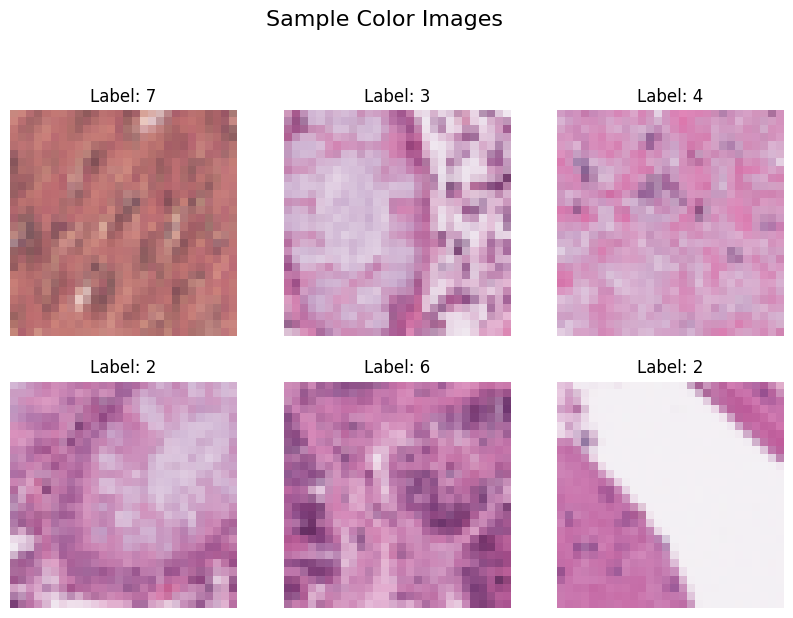

In [9]:
print("X_train shape:", X_train.shape)
print("X_train_1D shape:", X_train_1D.shape)
print("y_train shape:", y_train.shape)

print("y_train examples:", y_train[:5])
print("y_train_onehot shape:", y_train_onehot.shape)
print("y_train_onehot examples:", y_train_onehot[:5])

def plot_images(title, dataset:np.ndarray, labels:np.ndarray, num_images:int=6):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(dataset[i])
        plt.axis('off')
        plt.title(f"Label: {labels[i]}")
    plt.suptitle(title, fontsize=16)
    plt.show()

plot_images('Sample Color Images', X_train, y_train, num_images=6)

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [11]:
# random forest
name = "Random Forest"
model = RandomForestClassifier(n_estimators=100, random_state=42)

try:
    # Train the model
    model.fit(X_train_1D, np.argmax(y_train_onehot, axis=1))

    # Evaluate on training set
    train_preds = model.predict(X_train_1D)
    train_score = accuracy_score(np.argmax(y_train_onehot, axis=1), train_preds)
    print(f"{name} - Accuracy on training set: {train_score:.3f}")

    # Evaluate on validation set
    val_preds = model.predict(X_val_1D)
    val_score = accuracy_score(np.argmax(y_val_onehot, axis=1), val_preds)
    print(f"{name} - Accuracy on validation set: {val_score:.3f}")

    # Evaluate on test set
    test_preds = model.predict(X_test_1D)
    test_score = accuracy_score(np.argmax(y_test_onehot, axis=1), test_preds)
    print(f"{name} - Accuracy on test set: {test_score:.3f}\n")

except Exception as e:
    print(f"Error in {name}: {e}\n")

Random Forest - Accuracy on training set: 1.000
Random Forest - Accuracy on validation set: 0.642
Random Forest - Accuracy on test set: 0.640



### Fully connected neural network

In [ ]:
def build_fc_model(hp: kt.HyperParameters, best_model:bool=False) -> keras.models.Sequential:
    """Builds fully connected model with tunable hyperparameters.
Args:
    hp (kt.HyperParameters): HyperParameters object from kerastuner.
    best_model (bool, optional): If True, use the best hyperparameters. 
                                Otherwise, use tunable ones. Defaults to False.
    Returns: keras.models.Sequential: The compiled model.
"""
    # if best_model is True, use the best hyperparameters
    if best_model:
        num_layers = 5
        num_units = 448
        dropout_rate = 0
        learning_rate = 1e-4
    else:
        # tunable hyperparameters
        num_layers = hp.Int('num_layers', min_value=2, max_value=5)
        num_units = hp.Int('num_units', min_value=64, max_value=512, step=64)
        dropout_rate = hp.Float('dropout_rate', 0, 0.5, step=0.1)
        learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    
    model = keras.models.Sequential([
        keras.layers.Input(shape=(28, 28, 3)),
        keras.layers.Flatten(),
    ])

    for _ in range(num_layers):
        model.add(keras.layers.Dense(units=num_units, activation='relu'
        ))
        model.add(keras.layers.Dropout(rate=dropout_rate))
    
    model.add(keras.layers.Dense(units=9, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Convolutional neural network

In [29]:
def build_cnn_model(hp: kt.HyperParameters, best_model:bool=False) -> keras.models.Sequential:
    """Builds CNN model with tunable hyperparameters.
Args:
    hp (kt.HyperParameters): HyperParameters object from kerastuner.
    best_model (bool, optional): If True, use the best hyperparameters. 
                                Otherwise, use tunable ones. Defaults to False.
    Returns: keras.models.Sequential: The compiled CNN model.
"""
    
    if best_model: 
        conv_blocks = 3
        filters_start = 32
        kernel_size = 3
        pool_type = 'max'
        dropout_rate = 0
        learning_rate = 1e-3
    else:
        # Tunable hyperparameters
        conv_blocks   = hp.Int('conv_blocks', 2, 4)
        filters_start = hp.Choice('filters_start',[8, 16, 32]) 
        kernel_size   = hp.Choice('kernel_size', [3, 5])
        pool_type     = hp.Choice('pool_type', ['max', 'avg'])
        dropout_rate  = hp.Float('dropout_rate', 0.0, 0.5, step=0.25)
        learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28, 3)))

    # convolutional blocks
    for b in range(conv_blocks):
        filters = filters_start * 2**b                         # 32→64→128 …
        model.add(keras.layers.Conv2D(filters, kernel_size,
                                padding='same', activation='relu'))
        model.add(keras.layers.Conv2D(filters, kernel_size,
                                padding='same', activation='relu'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
        else:
            model.add(keras.layers.AveragePooling2D(pool_size=2, strides=2))
        model.add(keras.layers.Dropout(dropout_rate))

    # transition to dense head
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(9, activation='softmax'))

    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## 3. Hyperparameter tuning

### Common tuning method for MLP and CNN

In [30]:
def tune_nn_model(model, model_type: str):
    """Tune the neural network model using Keras Tuner. 
    Args:
        model: The model to be tuned.
        model_type: The type of the model (e.g., 'fc', 'cnn', etc.)."""

    # Set up the log directory for TensorBoard
    log_dir =f'tuning_logs/{model_type}'
    if os.path.exists(log_dir):
        # Remove the previous log directory if it exists
        shutil.rmtree(log_dir, ignore_errors=True)
    os.makedirs(log_dir)

    # Remove the previous keras_tuner directory if it exists
    if os.path.exists('keras_tuner'):
        shutil.rmtree('keras_tuner', ignore_errors=True)

    # Define the hypermodel
    tuner = kt.Hyperband(
        model,
        objective='val_accuracy',
        max_epochs=10,
        factor=2,
        directory='keras_tuner',
        project_name=model_type,
        seed=42,
    )
    # TensorBoard callback for logging and visualization of the tuning process
    tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Start the parameter search
    tuner.search_space_summary()
    tuner.search(
        X_train, y_train_onehot,
        epochs=30,
        validation_data=(X_val, y_val_onehot),
        verbose=1,
        callbacks=[tensorboard, early_stopping],
    )

    # Get the best hyperparameters and build the best model
    best_params = tuner.get_best_hyperparameters()[0]
    best_model = tuner._build_hypermodel(best_params)
    
    tuner.results_summary(num_trials=1)
    
    return best_model, best_params


### Algorithm of choice from first six weeks of course

In [12]:
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_random_search.fit(X_train_1D, np.argmax(y_train_onehot, axis=1))

print("Best Random Forest Parameters:", rf_random_search.best_params_)
print("Best Random Forest Training Accuracy:", rf_random_search.best_score_)

# Train the best model
best_rf = rf_random_search.best_estimator_
best_rf.fit(X_train_1D, np.argmax(y_train_onehot, axis=1))

# save the best model
joblib.dump(best_rf, 'best_models/best_random_forest_model.pkl')

# Evaluate on training set
train_preds = best_rf.predict(X_train_1D)
train_score = accuracy_score(np.argmax(y_train_onehot, axis=1), train_preds)
print(f"Random Forest - Accuracy on training set: {train_score:.3f}")

# Evaluate on validation set
val_preds = best_rf.predict(X_val_1D)
val_score = accuracy_score(np.argmax(y_val_onehot, axis=1), val_preds)
print(f"Random Forest - Accuracy on validation set: {val_score:.3f}")

# Evaluate on test set
test_preds = best_rf.predict(X_test_1D)
test_score = accuracy_score(np.argmax(y_test_onehot, axis=1), test_preds)
print(f"Random Forest - Accuracy on test set: {test_score:.3f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.9min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.0min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.0min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.5min
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 4

In [13]:
print("Best Random Forest Parameters:", rf_random_search.best_params_)

Best Random Forest Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}


### Fully connected neural network

In [32]:
# tune the model to find the best hyperparameters
best_model, best_params = tune_nn_model(build_fc_model, 'fc')

# train the best model
best_model.fit(
    X_train, y_train_onehot,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val_onehot),
    verbose=1
)

# evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)

best_model.save('best_models/best_fc_model.keras')
best_model.summary()

Trial 46 Complete [00h 00m 12s]
val_accuracy: 0.14546875655651093

Best val_accuracy So Far: 0.5787500143051147
Total elapsed time: 00h 08m 32s
Results summary
Results in keras_tuner/fc
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0031 summary
Hyperparameters:
num_layers: 3
num_units: 256
dropout_rate: 0.0
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0027
Score: 0.5787500143051147
Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4841 - loss: 1.3551 - val_accuracy: 0.5270 - val_loss: 1.2482
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5060 - loss: 1.3069 - val_accuracy: 0.3811 - val_loss: 1.6316
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5245 - loss: 1.2517 - val_accuracy: 0.5355 - val_loss: 1.2201
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5365 - loss: 1.2222 - val_accuracy: 0.5714 - val_loss: 1.1439


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       602,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,208,797 (8.43 MB)

 Trainable params: 736,265 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,472,532 (5.62 MB)

### Convolutional neural network

In [33]:
# tune the model to find the best hyperparameters
best_model, best_params = tune_nn_model(build_cnn_model, 'cnn')

# train the best model
best_model.fit(
    X_train, y_train_onehot,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val_onehot),
    verbose=1
)
# evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)

best_model.save('best_models/best_cnn_model.keras')
best_model.summary()


Trial 46 Complete [00h 00m 47s]
val_accuracy: 0.14546875655651093

Best val_accuracy So Far: 0.8220312595367432
Total elapsed time: 00h 36m 25s
Results summary
Results in keras_tuner/cnn
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0044 summary
Hyperparameters:
conv_blocks: 3
filters_start: 16
kernel_size: 3
pool_type: avg
dropout_rate: 0.0
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8220312595367432
Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3292 - loss: 1.7309 - val_accuracy: 0.5647 - val_loss: 1.1456
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5794 - loss: 1.1082 - val_accuracy: 0.6403 - val_loss: 0.9525
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6627 - loss: 0.9101 - val_accuracy: 0.7041 - val_loss: 0.7861
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7032 - loss: 0.7766 - val_accuracy: 0.7134 -

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 7, 7, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 3, 3, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441,293 (1.68 MB)

 Trainable params: 147,097 (574.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 294,196 (1.12 MB)

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

In [ ]:
def print_precision_recall(y_true, y_pred, classes):
    """
    Print Precision and Recall for each class.
    """
    for class_label in classes:
        precision = precision_score(y_true, y_pred, average=None, labels=[class_label])
        recall = recall_score(y_true, y_pred, average=None, labels=[class_label])
        print(f"Class {class_label}: Precision = {precision[0]:.4f}, Recall = {recall[0]:.4f}")


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

def plot_multiclass_precision_recall(y_true, y_probs, classes):
    """
    Plot Precision-Recall Curve for each class in a multiclass setting.
    """
    # Binarize the true labels for multiclass precision-recall calculation
    y_true_bin = label_binarize(y_true, classes=classes)
    
    plt.figure(figsize=(10, 7))
    
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        avg_precision = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall, precision, marker='.', label=f'Class {class_label} (AP = {avg_precision:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multiclass Precision-Recall Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


### Algorithm of choice from first six weeks of course

In [37]:
try: 
    # Load the saved model
    model_path = 'best_models/best_random_forest_model.pkl'
    best_rf = joblib.load(model_path)
    print("Model loaded successfully.")

except Exception as e:
    print(f"Could not load the model. Building a new one. Error: {e}")
    # If the model is not loaded, build a new one
    params = {
        'n_estimators': 400,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_depth': 20,
        'bootstrap': False
    }
    best_rf = RandomForestClassifier(**params)
    best_rf.fit(X_train_1D, np.argmax(y_train_onehot, axis=1))

# Evaluate on training set
train_preds = best_rf.predict(X_train_1D)
train_score = accuracy_score(np.argmax(y_train_onehot, axis=1), train_preds)
print(f"Random Forest - Accuracy on training set: {train_score:.3f}")

# Evaluate on validation set
val_preds = best_rf.predict(X_val_1D)
val_score = accuracy_score(np.argmax(y_val_onehot, axis=1), val_preds)
print(f"Random Forest - Accuracy on validation set: {val_score:.3f}")

# Evaluate on test set
test_preds = best_rf.predict(X_test_1D)
test_score = accuracy_score(np.argmax(y_test_onehot, axis=1), test_preds)
print(f"Random Forest - Accuracy on test set: {test_score:.3f}")

y_true = np.argmax(y_test_onehot, axis=1)

# Calculate precision and recall
precision = precision_score(y_true, test_preds, average='macro')
recall = recall_score(y_true, test_preds, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Model loaded successfully.
Random Forest - Accuracy on training set: 1.000
Random Forest - Accuracy on validation set: 0.667
Random Forest - Accuracy on test set: 0.672
Precision: 0.6838
Recall: 0.6503


plots for confusion matrix and precision recall curve

Confusion Matrix for Test Set - Random Forest Model:


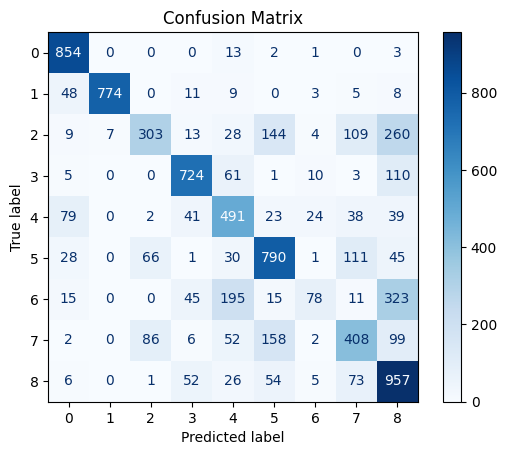

Precision-Recall Curve for Test Set - Random Forest Model:


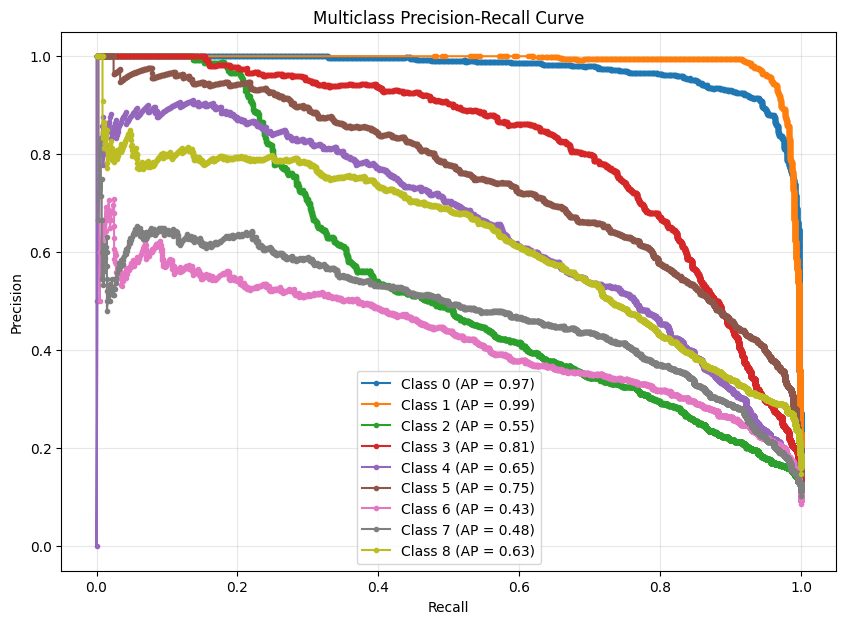

In [39]:
test_preds_rf = best_rf.predict(X_test_1D)
test_probs_rf = best_rf.predict_proba(X_test_1D)

classes_rf = np.unique(np.argmax(y_test_onehot, axis=1))

# Confusion Matrix
print("Confusion Matrix for Test Set - Random Forest Model:")
plot_confusion_matrix(np.argmax(y_test_onehot, axis=1), test_preds_rf)

# Precision-Recall Curve
print("Precision-Recall Curve for Test Set - Random Forest Model:")
plot_multiclass_precision_recall(np.argmax(y_test_onehot, axis=1), test_probs_rf, classes=classes_rf)

### Fully connected neural network

In [33]:
try:
    # Load the best FC model after tuning
    fc_model = keras.models.load_model('best_models/best_fc_model.keras')

except Exception:
    print(f"No saved model found. Building a new one.")

    # Create a dummy HyperParameters object since we're using best_model=True
    hp = kt.HyperParameters()
    
    # Build the CNN model with the best hyperparameters
    fc_model = build_fc_model(hp, best_model=True)

# Train the model on the training set
fc_model.fit(
    X_train, y_train_onehot,
    epochs=15,
    batch_size=16,
    validation_data=(X_val, y_val_onehot),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = fc_model.evaluate(X_test, y_test_onehot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_prob = fc_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# calculate precision and recall
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Epoch 1/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5552 - loss: 1.1414 - val_accuracy: 0.5856 - val_loss: 1.0746
Epoch 2/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5590 - loss: 1.1262 - val_accuracy: 0.5113 - val_loss: 1.2297
Epoch 3/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5661 - loss: 1.1057 - val_accuracy: 0.5827 - val_loss: 1.1025
Epoch 4/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5656 - loss: 1.1251 - val_accuracy: 0.5989 - val_loss: 1.0535
Epoch 5/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5719 - loss: 1.1073 - val_accuracy: 0.5733 - val_loss: 1.0965
Epoch 6/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5723 - loss: 1.0974 - val_accuracy: 0.5755 - val_loss: 1.1023
Epoch 7/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5710 - loss: 1.0921 - val_accuracy: 0.6120 - val_loss: 1.0293
Epoch 8/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5808 - loss: 1.0685 - 

plots for confusion matrix and precision recall curve

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
Confusion Matrix for Test Set:


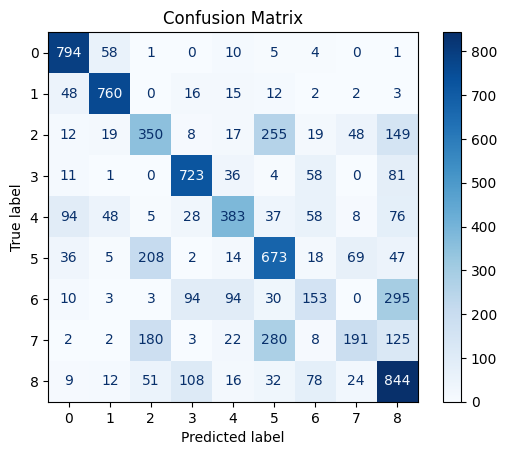

Precision-Recall Curve for Test Set:


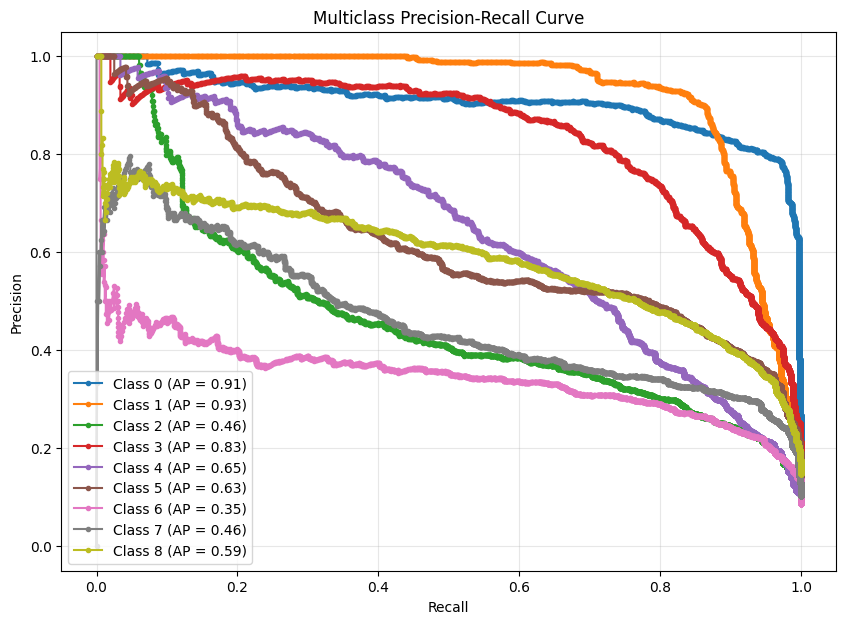

In [35]:
# Predictions 
test_probs = fc_model.predict(X_test)
test_preds = np.argmax(test_probs, axis=1)

# True Labels
y_test_labels = np.argmax(y_test_onehot, axis=1)
classes = np.unique(y_test_labels)

# Confusion Matrix
print("Confusion Matrix for Test Set:")
plot_confusion_matrix(y_test_labels, test_preds)

# Precision-Recall Curve
print("Precision-Recall Curve for Test Set:")
plot_multiclass_precision_recall(y_test_labels, test_probs, classes=classes)

### Convolutional neural network

In [36]:
try: 
    # Load the best CNN model after tuning
    cnn_model = keras.models.load_model('best_models/best_cnn_model.keras')

except Exception:
    print(f"No saved model found. Building a new one.")

    # Create a dummy HyperParameters object since we're using best_model=True
    hp = kt.HyperParameters()

    # Build the CNN model with the best hyperparameters
    cnn_model = build_cnn_model(hp, best_model=True)

# Train the model on the training set
cnn_model.fit(
    X_train, y_train_onehot,
    epochs=15,
    batch_size=16,
    validation_data=(X_val, y_val_onehot),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test_onehot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions and conversion to labels
y_pred_prob = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate precision and recall
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")




Epoch 1/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8347 - loss: 0.4471 - val_accuracy: 0.8213 - val_loss: 0.5010
Epoch 2/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8572 - loss: 0.3891 - val_accuracy: 0.8248 - val_loss: 0.4833
Epoch 3/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8633 - loss: 0.3664 - val_accuracy: 0.8269 - val_loss: 0.5003
Epoch 4/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8729 - loss: 0.3442 - val_accuracy: 0.8280 - val_loss: 0.4840
Epoch 5/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8745 - loss: 0.3350 - val_accuracy: 0.8230 - val_loss: 0.5107
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8257 - loss: 0.4859
Test Loss: 0.4837
Test Accuracy: 0.8246
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Precision: 0.8300
Recall: 0.8233


plots for confusion matrix and precision recall curve

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix for Validation Set:


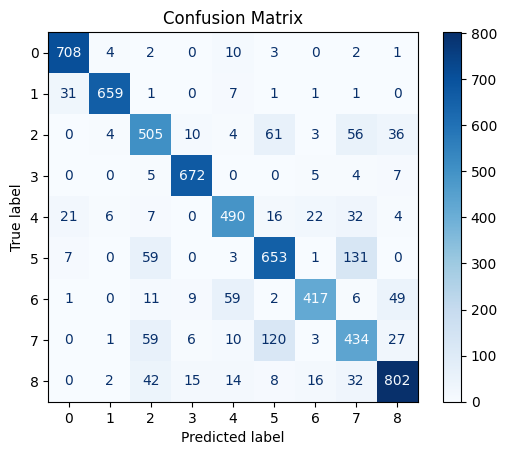

Precision-Recall Curve for Validation Set:


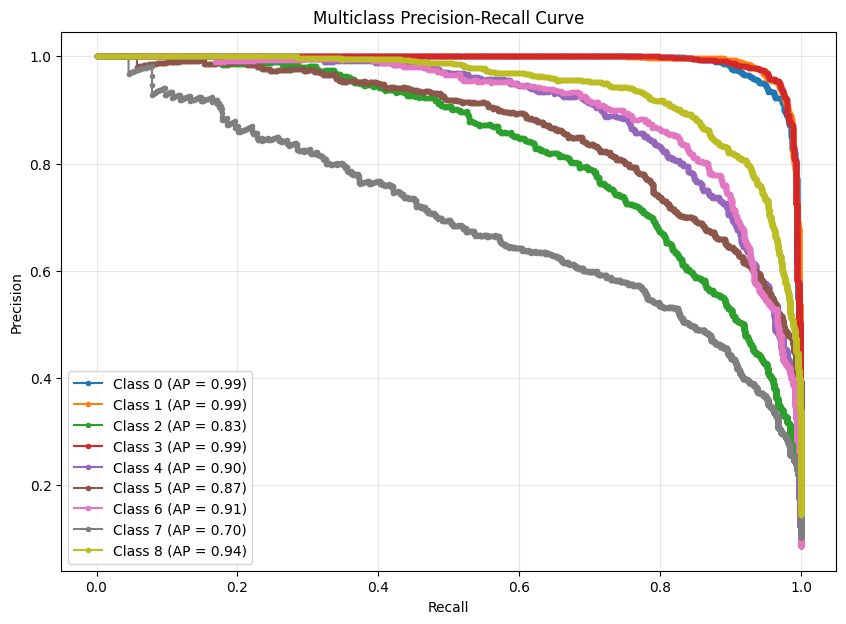

In [ ]:
test_probs_cnn = cnn_model.predict(X_test)
test_preds_cnn = np.argmax(test_probs_cnn, axis=1)
y_test_labels_cnn = np.argmax(y_test_onehot, axis=1)
classes_cnn = np.unique(y_test_labels_cnn)

# Confusion Matrix
print("Confusion Matrix for Test Set - CNN Model:")
plot_confusion_matrix(y_test_labels_cnn, test_preds_cnn)

# Precision-Recall Curve
print("Precision-Recall Curve for Test Set - CNN Model:")
plot_multiclass_precision_recall(y_test_labels_cnn, test_probs_cnn, classes=classes_cnn)

precision_cnn = precision_score(y_test_labels_cnn, test_preds_cnn, average='macro')
recall_cnn = recall_score(y_test_labels_cnn, test_preds_cnn, average='macro')

print(f"Precision: {precision_cnn:.4f}")
print(f"Recall: {recall_cnn:.4f}")